In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import json
import time
import logging
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, Image

from surprise import Reader, Dataset
from surprise import KNNBasic

from scipy.sparse import coo_matrix, csr_matrix, save_npz, load_npz

logger = logging.getLogger()
fhandler = logging.FileHandler(filename='mylog.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

# Load Data

In [2]:
DATA_FOLDER = "../input"
TMP_FOLDER = os.path.join(DATA_FOLDER, "tmp")
EXPLICIT_FOLDER = os.path.join(TMP_FOLDER, 'explicit_newuser')

train_matrix_file_name = 'train_matrix.npz'
test_csv_file_name = 'test_interactions.csv'
train_csv_file_name = 'train_interactions.csv'
metadata_file_name = 'metadata.json'

In [3]:
train_matrix = load_npz(os.path.join(EXPLICIT_FOLDER, train_matrix_file_name))
test_df = pd.read_csv(os.path.join(EXPLICIT_FOLDER, test_csv_file_name), dtype=str)
train_df = pd.read_csv(os.path.join(EXPLICIT_FOLDER, train_csv_file_name), dtype=str)
with open(os.path.join(EXPLICIT_FOLDER, metadata_file_name), 'r') as fp:
    metadata = json.load(fp)

In [ ]:
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0.5, 5.0))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

# Train and Validate Model

In [4]:
def top_k_accuracy(ground_series, rec_dict, k):
    if k == 0:
        return 0
    
    acc = 0
    count = 0
    for user_id in test_user_item_index.index.levels[0]:
        top_k_rec = rec_dict[user_id][0:min(k, len(rec_dict[user_id]))]
        if ground_series[user_id].shape[0] == 0:
            continue
        
        # number of intersetion items
        num_match = ground_series[user_id].isin(top_k_rec).map(lambda ele: 1.0 if ele else 0.0).sum()
        
        acc += num_match / min(len(top_k_rec), ground_series[user_id].shape[0])
        
        count += 1
        
    acc /= count
    
    return acc

def top_k_accuracy_bins(ground_series, rec_dict, k, train_series, bins=5):
    if k == 0:
        return 0
    
    acc = dict()
    count = dict()
    for user_id in rec_dict.keys():
        top_k_rec = rec_dict[user_id][0:min(k, len(rec_dict[user_id]))]
        if ground_series[user_id].shape[0] == 0:
            continue
        
        if isinstance(bins, list):
            bin_index = bs(bins, train_series[user_id].shape[0])
        else:
            bin_index = (train_series[user_id].shape[0] // bins) * bins
            
        # number of intersetion items
        num_match = ground_series[user_id].isin(top_k_rec).map(lambda ele: 1.0 if ele else 0.0).sum()
        
        if bin_index not in acc:
            acc[bin_index] = 0.0
            count[bin_index] = 0
        acc[bin_index] += (num_match / min(len(top_k_rec), ground_series[user_id].shape[0])) if len(top_k_rec) > 0 else 0
        count[bin_index] += 1
    
    print("mean top k accuracy: " + str(np.asarray(list(acc.values())).sum() / np.asarray(list(count.values())).sum()))
    
    for bin_index in acc.keys():
        acc[bin_index] /= count[bin_index]
    
    return pd.Series(acc, index=sorted(list(acc.keys())))

def bs(a, target):
    if target > a[-1]:
        return len(a)

    lo, hi = 0, len(a)-1
    
    while lo < hi:
        mid = lo + int((hi - 1) / 2)
        if target < a[mid]:
            hi = mid
        elif target > a[mid]:
            lo = mid + 1
        else:
            return mid
        
    return lo

In [5]:
test_user_item = test_df.groupby('USER_ID').apply(lambda group: group['ITEM_ID'])
test_user_item_index = test_user_item.map(lambda ele: metadata['item_index'][ele])

In [6]:
train_user_item = train_df.groupby('USER_ID').apply(lambda group: group['ITEM_ID'])
train_user_item_index = train_user_item.map(lambda ele: metadata['item_index'][ele])

In [7]:
test_user_item_index.index.levels[0]

Index(['0004f3a6-6912-4e36-a6a8-443d3277a750',
       '00087e6a-1ea1-4598-bc6f-c29a4eb2be44',
       '0008f2d1-13f2-4a67-86c6-be74a34de938',
       '000cdf6c-7d82-4aea-b07b-af67226be1bc',
       '000fe44f-65ec-4c74-ac28-eff76ba5e0b8',
       '00113df2-f71f-4002-a189-b0212d3b904a',
       '00118413-748a-49e5-b1dc-4944a465567b',
       '0013c053-d61f-437e-8df0-0e0b15529b0b',
       '0014a16f-a4b4-4127-83a3-32f5aab0f7e5',
       '001514a0-468d-4567-a1df-87ee067c8dd5',
       ...
       '264fcb80-48a1-4743-a8d7-94d02380af98',
       '265225bf-905d-44e1-8869-86c59fce022d',
       '2652f4e0-97d4-4792-9676-c5721afeb5c8',
       '26548367-ac89-4427-b6e0-2fbc957e40f1',
       '2655d6a7-8e22-477b-830a-b6d33eddbf76',
       '2655f429-729c-47cd-8310-99d16cb9807d',
       '265f9a4f-cd89-4106-a316-44287174c6f4',
       '265fb6f2-324d-4c2a-a649-c44682a7911e',
       '26653649-0c7d-4840-ab49-9c8e1d7666e1',
       '26656774-2b3a-44ed-b737-874fff4d93c2'],
      dtype='object', name='USER_ID', length=237

# COS

### Training

In [42]:
model_name = "cos"

In [50]:
model = nearest_neighbours.CosineRecommender(K=1000)

In [51]:
start = time.time()
model.fit(train_matrix)
print("trained model '%s' in %s", model_name, time.time() - start)

100%|██████████| 152053/152053 [00:04<00:00, 37541.48it/s]


trained model '%s' in %s cos 32.219868898391724


### Testing

In [56]:
rec_train_user_item_index = dict()
for user_id in train_user_item_index.index.levels[0]:
    rec_res = model.recommend(metadata['user_index'][user_id], train_matrix)
    rec_res = [ele[0] for ele in rec_res]
    rec_train_user_item_index[user_id] = rec_res
topkbins = top_k_accuracy_bins(train_user_item_index, rec_train_user_item_index, 10, train_user_item_index, bins=30)

mean top k accuracy: 0.005305039787798408


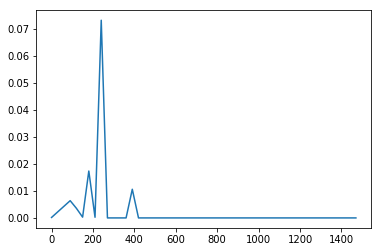

In [57]:
topkbins.plot(kind='line')

In [58]:
rec_test_user_item_index = dict()
for user_id in test_user_item_index.index.levels[0]:
    rec_res = model.recommend(metadata['user_index'][user_id], train_matrix, N=10, filter_items=train_user_item_index[user_id].values.tolist())
    rec_res = [ele[0] for ele in rec_res]
    rec_test_user_item_index[user_id] = rec_res
topkbins = top_k_accuracy_bins(test_user_item_index, rec_test_user_item_index, 10, train_user_item_index, bins=1)

mean top k accuracy: 0.0012626262626262625


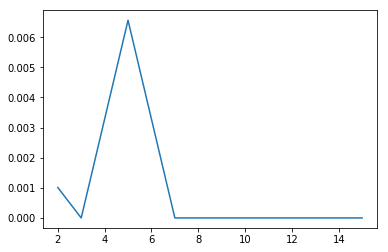

In [59]:
topkbins.plot(kind='line')

## TFIDF

### Training

In [15]:
model_name = "tfidf"

In [16]:
model = nearest_neighbours.TFIDFRecommender(K=5)

In [17]:
start = time.time()
model.fit(train_matrix)
print("trained model '%s' in %s", model_name, time.time() - start)

100%|██████████| 152053/152053 [00:02<00:00, 60725.64it/s]

trained model '%s' in %s tfidf 2.613616943359375


### Testing

In [18]:
rec_train_user_item_index = dict()
for user_id in train_user_item_index.index.levels[0]:
    rec_res = model.recommend(metadata['user_index'][user_id], train_matrix, N=10)
    rec_res = [ele[0] for ele in rec_res]
    rec_train_user_item_index[user_id] = rec_res
topkbins = top_k_accuracy_bins(train_user_item_index, rec_train_user_item_index, 10, train_user_item_index, bins=1)

mean top k accuracy: 0.002627257799671593


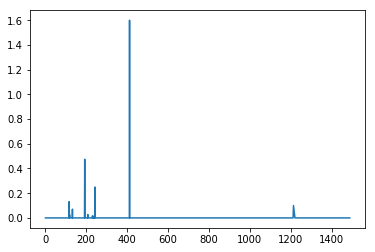

In [19]:
topkbins.plot(kind='line')

In [20]:
rec_test_user_item_index = dict()
for user_id in test_user_item_index.index.levels[0]:
    rec_res = model.recommend(metadata['user_index'][user_id], train_matrix, N=10, filter_items=train_user_item_index[user_id].values.tolist())
    rec_res = [ele[0] for ele in rec_res]
    rec_test_user_item_index[user_id] = rec_res
topkbins = top_k_accuracy_bins(test_user_item_index, rec_test_user_item_index, 10, train_user_item_index, bins=1)

mean top k accuracy: 0.0008417508417508417


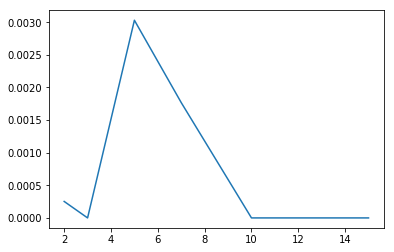

In [21]:
topkbins.plot(kind='line')

# Show Images

In [53]:
max_index = max(metadata['item_index'].values())
item_indices = list(range(max_index+1))
for key, val in metadata['item_index'].items():
    item_indices[val] = key

In [60]:
def show_training_data(user_id):
    print(train_user_item_index[user_id].values.shape)
    for id_ in train_user_item_index[user_id].values.tolist():
        plt.figure()
        display(Image(filename=os.path.join(DATA_FOLDER, "exercise.thumbnails/") + item_indices[id_] + '.jpg'))

def show_top_k(user_id, k):
    item_index = model.recommend(metadata['user_index'][user_id], train_matrix, N=10, filter_items=train_user_item_index[user_id].values.tolist())
    print(len(item_index))
    for id_ in item_index:
        plt.figure()
        display(Image(filename=os.path.join(DATA_FOLDER, "exercise.thumbnails/") + item_indices[id_[0]] + '.jpg'))

# Examples

### Example 1

(3,)


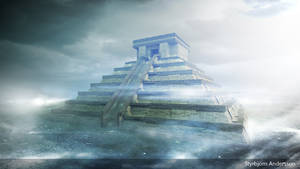

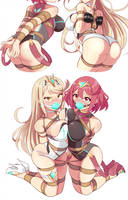

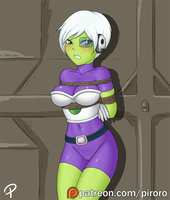

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [62]:
user_id = '26656774-2b3a-44ed-b737-874fff4d93c2'
show_training_data(user_id)

10


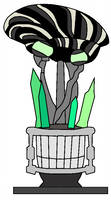

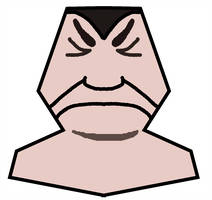

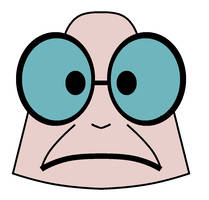

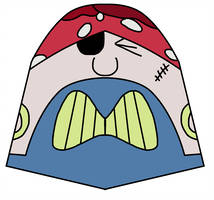

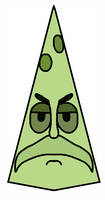

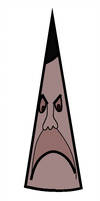

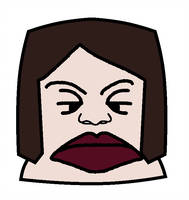

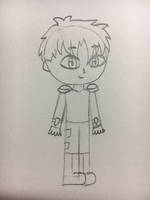

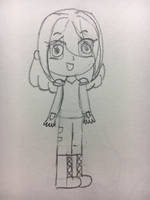

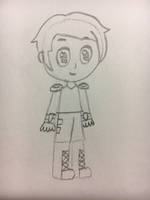

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [63]:
show_top_k(user_id, 10)

### Example 2

(7,)


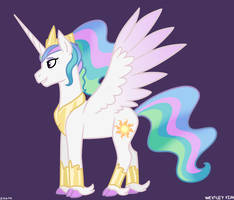

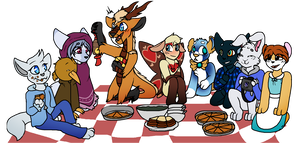

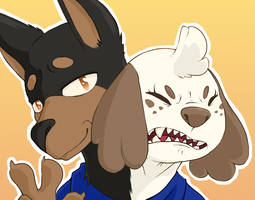

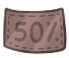

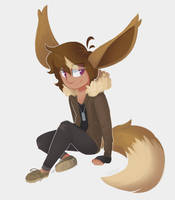

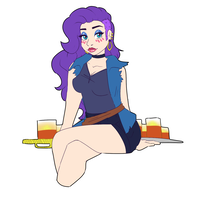

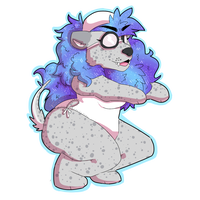

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [67]:
user_id = '001514a0-468d-4567-a1df-87ee067c8dd5'
show_training_data(user_id)

10


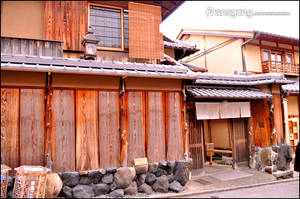

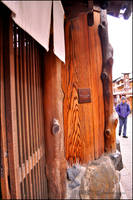

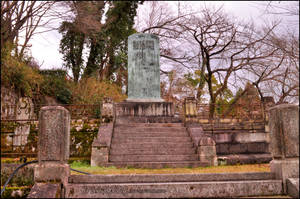

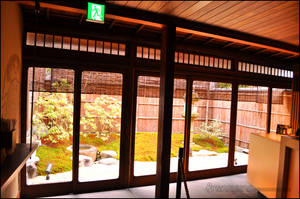

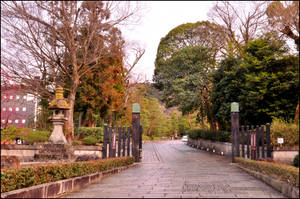

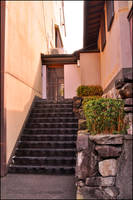

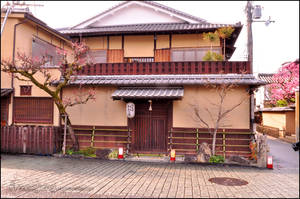

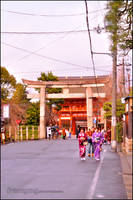

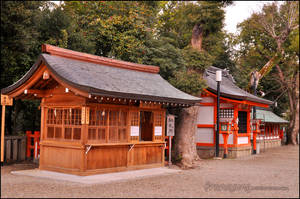

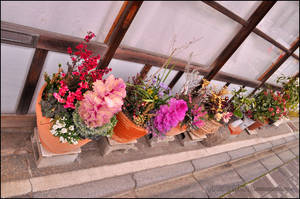

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [68]:
show_top_k(user_id, 10)

### Example 3

(7,)


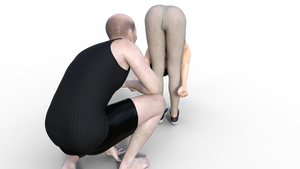

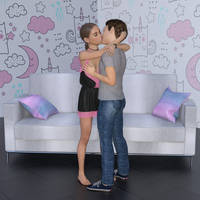

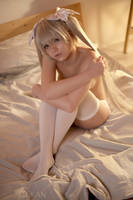

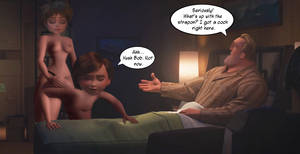

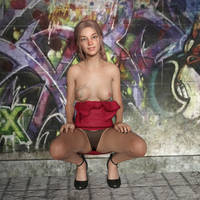

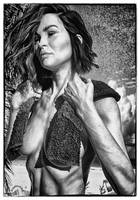

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [71]:
user_id = '265225bf-905d-44e1-8869-86c59fce022d'
show_training_data(user_id)

10


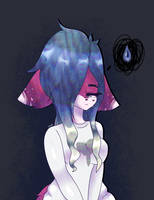

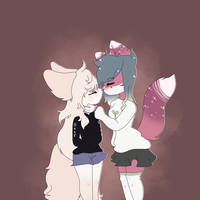

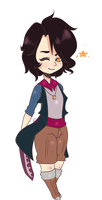

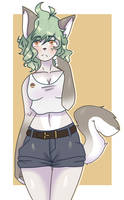

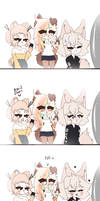

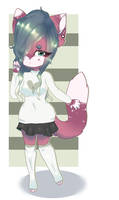

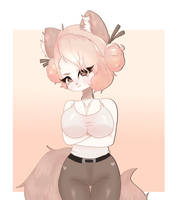

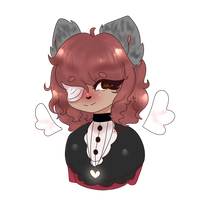

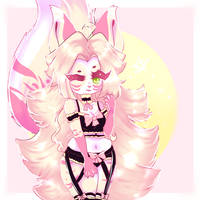

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [72]:
show_top_k(user_id, 10)